# The Role of Recurrent Transitions in RGNNs for Graph Classification

Social networks represent a rich source of graph data, and due to the popularity of social networking applications, accurate user and community classifications have become exceedingly important for the purpose of analysis, marketing, and influencing. 

In this example, we look at how the recurrent application of a transition function aids in making predictions on the graph domain, namely, in graph classification.

## Setup
Here we load required libraries, define paths to data, and define some helper functions. **Feel free to skip this section.**

In [1]:
!pip install dgl
import numpy as np
import math
import json
import networkx as nx
import itertools

from IPython.display import HTML
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt

import dgl
from dgl.nn.pytorch import GraphConv

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn import metrics
from sklearn import manifold

Using backend: pytorch


In [2]:
# Helper function to visualize stargazer dataset graphs
def plot_stargazer_graph(G, label=None, print_info=False, labels=True):
    # Print info with graph if we want
    if print_info:  
        print(f"{G.number_of_nodes()} vertices")
        print(f"{G.number_of_edges()} edges")
        
    # Grey if no label, pink if 0, green if 1
    col = [[0.7, 0.7, 0.7]]
    if label is not None:
        if label == 0:
            col = [[0.6, 0, 0.6]]
        elif label == 1:
            col = [[0, 0.5, 0]]
    
    # Visualise as undirected
    nx_G = G.to_networkx().to_undirected()
    
    # Use the recommended Kamada-Kawaii layout for arbitrary graphs
    pos = nx.kamada_kawai_layout(nx_G)
    nx.draw(nx_G, pos, with_labels=labels, node_color=col)

In [3]:
# Helper function to visualize the webmluser graph
def plot_webmluser_graph(G):    
    # Visualise as undirected
    nx_G = G.to_networkx().to_undirected()
    
    # Use the recommended Kamada-Kawaii layout for arbitrary graphs
    pos = nx.kamada_kawai_layout(nx_G)
    nx.draw(nx_G, pos, node_color=[[0.7, 0.7, 0.7]])

In [4]:
# Helper for getting batches from a dataset
def get_batches(xs, ys, batch_size=16):
    # How many batches is there of given size for this dataset
    num = len(xs)
    num_batches = math.ceil(num / batch_size)
    
    # Go through and get all batches
    batches_x = []
    batches_y = []
    
    # Get all batches in memory
    for i in range(num_batches - 1):
        sidx = batch_size * i
        fidx = batch_size * (i + 1)
        fidx = min(fidx, num)
        batches_x.append(xs[sidx:fidx])
        batches_y.append(ys[sidx:fidx])
        
    return batches_x, batches_y

## Datasets
We'll introduce two distinct kinds of graph datasets through the following examples.


### GitHub Stargazers Dataset
12,725 graphs of undirected developer social networks. Again, vertices are users who starred popular machine learning and web development repositories (with at least 10 stars), and edges are mutual follower relationships. The task is to classify each graph as a machine learning, or web development social network.

**In this dataset, each training sample is a distinct graph.**

In [5]:
# if you have cloned the repo from Github and have the data locally, 
# set this to True
LOCAL = True

if LOCAL:
  # set this path to where you have the data locally
  fp_data = "./datasets"
else:
  !git clone https://github.com/zephyros-solutions/gnn-tutorial.git
  fp_data = "./gnn-tutorial/notebooks/datasets"

fp_data_stargazer = f"{fp_data}/github_stargazers"
fp_data_webmluser = f"{fp_data}/git_web_ml"

# Load the ground truth labels. Every element here is a 
# [graph index, label] pair
stargazer_labels = np.loadtxt(f"{fp_data_stargazer}/git_target.csv", \
                                      delimiter=",", skiprows=1)

    
# Adopting the accepted ML notation of input data (x) and labels (y)
stargazer_y = stargazer_labels[:,1].astype(int)

print(stargazer_y)

[0 0 1 ... 1 0 0]


In [6]:
# Then we'll load the edges (defined against vertex ids) - note that there
# are no node or edge features, so predictions are made purely based on 
# undirected graph properties
with open(f"{fp_data_stargazer}/git_edges.json") as f:
  stargazer_edges = json.load(f)

# print(stargazer_edges)

In [7]:
# Every item in this dictionary are the edges for a single graph, where each 
# edge is defined as a [vertex index, vertex index] pair. Here we show the 
# first 10 edges from graph 19
stargazer_edges['19'][:10]

[[0, 15],
 [1, 18],
 [1, 3],
 [1, 22],
 [1, 7],
 [1, 9],
 [1, 31],
 [2, 16],
 [3, 16],
 [3, 22]]

In [8]:
# This function takes the data loaded in the stargazer dataset form and turns 
# it into a DGL graph
def make_stargazer_graph(index):
    # Define every edge by its source and destination vertex ids
    edges = np.array(stargazer_edges[f"{index}"])
    src = edges[:,0]
    dst = edges[:,1]
    
    # Edges are directional in DGL; Make them undirectional by making them 
    # go both ways
    u = np.concatenate([src, dst])
    v = np.concatenate([dst, src])
    
    # Construct a DGLGraph
    return dgl.graph((u, v))

In [9]:
# We can use this data to build each of the 12725 graphs as a single DGL
# graph object, thus forming our graph dataset
stargazer_x = []
for i in range(12725):
    G = make_stargazer_graph(i)
    stargazer_x.append(G)

38 vertices
110 edges


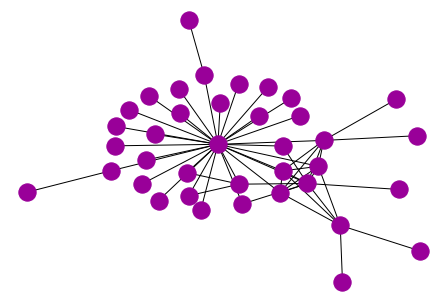

In [10]:
# Lets look at one of our graphs (pink for class 0, green for class 1)
plot_stargazer_graph(stargazer_x[19], label=stargazer_y[19], print_info=True, labels=False)

128 vertices
880 edges


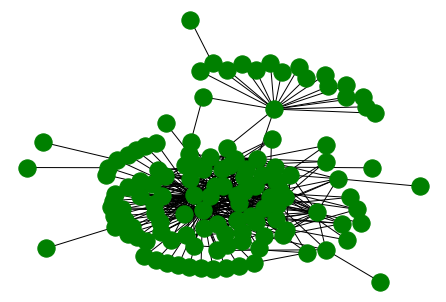

In [11]:
# Lets look at another - noting that the structure alone will be the inputs 
# to the GNN (no vertex or edge features), and that this will be sufficient
# to determine if the social network group is a ML developer group or 
# a Web developer group
plot_stargazer_graph(stargazer_x[2], label=stargazer_y[2], print_info=True, labels=False)

### GitHub Web or Machine Learning Dataset
One single graph representing the GitHub social network: vertices are users (who have starred at least 10 repositories) and edges represent if they mutually follow eachother. Each node has input features derived from profile data (location, repositories starred, employer and e-mail address), and belongs to one of two classes (derived from the user's job title): a web developer or machine learning developer. 

**Note that using a single graph represents a departure from traditional supervised machine learning, where we typically use hundreds or thousands of training instances**. In this application, it is perhaps easier to consider the **vertices** of the graph as training instances. Indeed, we would reserve some vertices for training and some for testing.

In [12]:
# Lets start by loading the vertices with their ground truth labels 
# and names attached. Every element is a [vertex index, name, label] triplet
webmluser_labels = np.loadtxt(f"{fp_data_webmluser}/musae_git_target.csv", \
                                  delimiter=",", skiprows=1, usecols=[0,2])
webmluser_y = webmluser_labels[:,1].astype(int)
print(webmluser_labels)

[[0.0000e+00 0.0000e+00]
 [1.0000e+00 0.0000e+00]
 [2.0000e+00 1.0000e+00]
 ...
 [3.7697e+04 0.0000e+00]
 [3.7698e+04 1.0000e+00]
 [3.7699e+04 0.0000e+00]]


In [13]:
# Now load the associated vertex features
with open(f"{fp_data_webmluser}/musae_git_features.json") as f:
    webmluser_features = json.load(f)

In [14]:
# There are 37700 vertices here, with each index keying into the features
# dictionary we just loaded. Here is an example of one vertex's features
print(webmluser_features['9001'])

[2657, 509, 3214, 3541, 3129, 1852, 3077, 3763, 536, 137, 2788, 1532, 3771, 234, 1991, 3813, 1651, 3887]


In [15]:
# Then we'll load the edges (defined against vertex id pairs)
webmluser_edges = np.loadtxt(f"{fp_data_webmluser}/musae_git_edges.csv", \
                                  delimiter=",", skiprows=1)

In [16]:
print(type(webmluser_edges[0,0]))
# We only need to make one graph here, and that is our 'dataset'
def make_webmluser_graph():
    # Define every edge by its source and destination vertex ids
    src = webmluser_edges[:,0].astype(int)
    dst = webmluser_edges[:,1].astype(int)
    
    # Edges are directional in DGL; Make them undirectional by making them 
    # go both ways
    u = np.concatenate([src, dst])
    v = np.concatenate([dst, src])
    
    # Construct a DGLGraph
    G = dgl.graph((u, v))
    
    return G

<class 'numpy.float64'>


In [17]:
# Build the graph from the data - note that this is a big graph
webmluser_x = make_webmluser_graph()
print(f"{webmluser_x.number_of_nodes()} nodes")
print(f"{webmluser_x.number_of_edges()} edges")

37700 nodes
578006 edges


In [18]:
# For the purpose of this example, we will consider only the
# Stargazer's Dataset, but its good to be aware of different kinds of 
# datasets

## Architectures
True RGNNs are seldom used in contemporary GNN work. RGNNs require a transition function to be repeatedly applied until convergence of the hidden states - an expensive computation. Instead of use true RGNNs here, we'll use GCNs with varying numbers of layers, thus mimicking the repeated application of a transition function.

In [19]:
# We want to experiment with the amount of computation required in the 
# forward pass, so we'll build various GNNs here, each with different 
# numbers of transition function layers
class StargazerGNN(nn.Module):
    def __init__(self, num_hidden_features):
        super().__init__()
        
        # We'll apply some number of spatial convolutions / message passing 
        # RGNNs
        self.convs = nn.ModuleList()
        for i in range(len(num_hidden_features) - 1):
            self.convs.append(GraphConv(num_hidden_features[i], 
                                        num_hidden_features[i+1]))
            
        # Classify out to one of two classes
        self.classify = nn.Linear(num_hidden_features[-1], 2)

    def forward(self, g):
        # Start with just the degree as a feature
        h = g.in_degrees().view(-1, 1).float()
        for i in range(len(self.convs)):
            h = self.convs[i](g, h)
            h = torch.relu(h)
            
        # Calculate graph representation by averaging all the node 
        # representations, thus making a graph representation
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')
        output = self.classify(hg)
        return output

    def hidden(self, g):
        # Start with just the degree as a feature
        h = g.in_degrees().view(-1, 1).float()
        for i in range(len(self.convs)):
            h = self.convs[i](g, h)
            h = torch.relu(h)
        
        return h

## Experiments
Now we'll perform our experiments, we want to create GNNs which use learned transition functions of increasing complexity. 

We'll start by defining a training and testing procedure, and then we'll produce and discuss some results.

### Training and Testing
We'll use a learning rate of 0.001, MSE Loss in our loss function, and a batch size of 64.

In [20]:
# The following operations will train the GNN
def train_stargazer_gnn(gnn, num_epochs):
    loss_func = nn.MSELoss()
    opt = torch.optim.Adam(itertools.chain(gnn.parameters()), 
                           lr=0.001)

    # Get the batches to work with
    num_train = 8096
    batches_x, batches_y = get_batches(stargazer_x[:num_train], \
                                       stargazer_y[:num_train], \
                                       batch_size=64)

    # Run every batch in every epoch
    epoch_losses = []
    for epoch_index in range(num_epochs):
        epoch_loss = 0
        for batch_index in range(len(batches_x)):
            # Get the batch of interest
            batch_x = batches_x[batch_index]
            batch_y = batches_y[batch_index]

            # Calculate an output for each graph
            x = dgl.batch(batch_x)
            y_hat = gnn(x)

            # And compare to the true value
            y = F.one_hot(torch.tensor(batch_y), num_classes=2).float()

            #print(y_hat)
            #print(y)

            # Calculate loss 
            loss = loss_func(y_hat, y)

            # Calculate loss and perform gradient descent step accordingly
            opt.zero_grad()
            loss.backward()
            opt.step()

            epoch_loss += loss.item()
        epoch_loss /= len(batches_x)
        print(f"Epoch {epoch_index}: loss {epoch_loss}")
        epoch_losses.append(epoch_loss)
        
    # Return the trained architecture and loss
    return epoch_losses
    

In [21]:
# The following operation will test the GNN, returning hidden representations and 
# predictions
def test_stargazer_gnn(gnn):
    num_train = 8096
    num_test = 2048

    batches_x, batches_y = get_batches(stargazer_x[num_train:num_train+num_test],\
                                       stargazer_y[num_train:num_train+num_test],\
                                       batch_size=1)

    num_correct = 0
    y_true = []
    y_pred = []
    hidden = []
    for batch_index in range(len(batches_x)):
        # Get the batch of interest
        batch_x = batches_x[batch_index]
        batch_y = batches_y[batch_index]

        # Calculate an output for each graph
        x = dgl.batch(batch_x)
        y_hat = gnn(x)
        y_hat = torch.argmax(y_hat, dim=1).detach().numpy()

        # Also get some hidden representations for plotting
        h = torch.mean(gnn.hidden(x), dim=0).detach().numpy()
        hidden.append(h)

        # Take note of everything
        y_pred.extend(y_hat)
        y_true.extend(batch_y)
    hidden = np.array(hidden)
    
    return hidden, y_true, y_pred

As en example, lets now use these functions to train and test a Stargazer GNN.

In [22]:
stargazer_gnn_example = StargazerGNN([1, 16, 16, 16, 16, 16, 16, 16])
epoch_losses = train_stargazer_gnn(stargazer_gnn_example, 8)

Epoch 0: loss 0.31237054769954986
Epoch 1: loss 0.2524848425435641
Epoch 2: loss 0.24370474462944364
Epoch 3: loss 0.24102592562872266
Epoch 4: loss 0.23785390385559627
Epoch 5: loss 0.23489329774701406
Epoch 6: loss 0.23154244583750527
Epoch 7: loss 0.22828202481780732


In [23]:
hidden, y_true, y_pred = test_stargazer_gnn(stargazer_gnn_example)

In [24]:
print(metrics.classification_report(y_true, y_pred, \
                                    target_names=['web', 'ml']))
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
print(f"AUC\t{metrics.auc(fpr, tpr)}")

              precision    recall  f1-score   support

         web       0.65      0.50      0.56       991
          ml       0.61      0.75      0.68      1056

    accuracy                           0.63      2047
   macro avg       0.63      0.62      0.62      2047
weighted avg       0.63      0.63      0.62      2047

AUC	0.6242431886982845


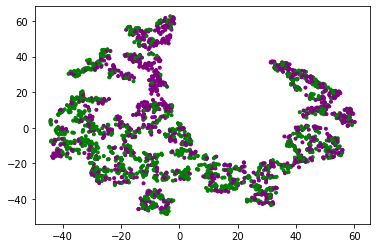

In [25]:
# Plot a TSNE fit on the features
tsne = manifold.TSNE(n_components=2)
tsne_embedded = tsne.fit_transform(hidden)
tsne_embedded.shape
plt.scatter(tsne_embedded[:,0], tsne_embedded[:,1], \
            marker='.', c=y_true, 
            cmap=matplotlib.colors.ListedColormap(['purple', 'green']))

As expected, the loss decreases (with ultimately diminishing returns) over the 8 epochs. Ultimately the features become more separable, as shown by the TSNE plot.

### Results and Discussion

Now lets wrap all this up into one function so we can test multiple architectures.

In [26]:
def train_test_architecture(num_hidden_features, num_epochs, plot_loss=False):
    # Make architecture and train
    gnn_run = StargazerGNN(num_hidden_features)
    epoch_losses = train_stargazer_gnn(gnn_run, num_epochs)
    
    if num_epochs > 0 and plot_loss:
        plt.plot(range(num_epochs), epoch_losses)
        plt.ylim((0, 1.0))
        plt.title("Loss during training")
        plt.show()
    
    # Test and return hidden representations plus predictions
    hidden, y_true, y_pred = test_stargazer_gnn(gnn_run)
    
    # Print performance metrics
    print(metrics.classification_report(y_true, y_pred, \
                                        target_names=['web', 'ml']))
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    print(f"AUC\t{metrics.auc(fpr, tpr)}")
    
    # Plot TSNE visualization
    tsne = manifold.TSNE(n_components=2)
    tsne_embedded = tsne.fit_transform(hidden)
    tsne_embedded.shape
    plt.scatter(tsne_embedded[:,0], tsne_embedded[:,1], \
                marker='.', c=y_true, 
                cmap=matplotlib.colors.ListedColormap(['purple', 'green']))

Now lets conduct some experiments - we keep the number of epochs consistent and vary the number of layers in the transition function. This is similar to the examples ran in section B.1 in the paper.

Epoch 0: loss 0.3595548506293978
Epoch 1: loss 0.31154197123315597
Epoch 2: loss 0.2780538068877326
Epoch 3: loss 0.25821669648091
Epoch 4: loss 0.2498550843151789
Epoch 5: loss 0.2474209468752619
              precision    recall  f1-score   support

         web       0.51      0.23      0.32       991
          ml       0.52      0.79      0.63      1056

    accuracy                           0.52      2047
   macro avg       0.52      0.51      0.47      2047
weighted avg       0.52      0.52      0.48      2047

AUC	0.5109928752713818


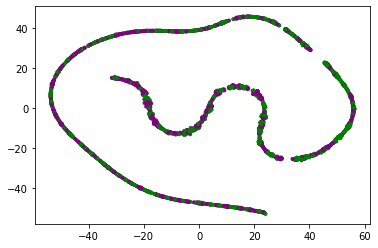

In [27]:
train_test_architecture([1, 16], 6)

Epoch 0: loss 0.29172861268596045
Epoch 1: loss 0.261917893257406
Epoch 2: loss 0.2496028897308168
Epoch 3: loss 0.24713672047096585
Epoch 4: loss 0.24634211001888154
Epoch 5: loss 0.24555689522198268
              precision    recall  f1-score   support

         web       0.60      0.22      0.32       991
          ml       0.54      0.86      0.66      1056

    accuracy                           0.55      2047
   macro avg       0.57      0.54      0.49      2047
weighted avg       0.57      0.55      0.50      2047

AUC	0.5408300652845305


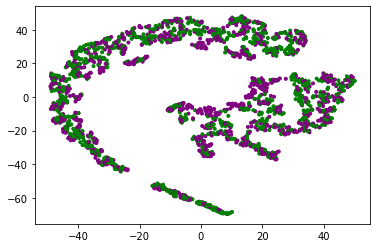

In [28]:
train_test_architecture([1, 16, 16], 6)

Epoch 0: loss 0.3635846840010749
Epoch 1: loss 0.2583737864144265
Epoch 2: loss 0.248903855444893
Epoch 3: loss 0.24631510627648187
Epoch 4: loss 0.24500221132286013
Epoch 5: loss 0.2427948344321478
              precision    recall  f1-score   support

         web       0.58      0.47      0.52       991
          ml       0.58      0.68      0.62      1056

    accuracy                           0.58      2047
   macro avg       0.58      0.57      0.57      2047
weighted avg       0.58      0.58      0.57      2047

AUC	0.5747289048405345


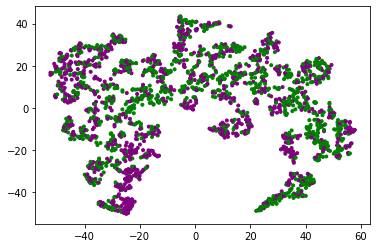

In [29]:
train_test_architecture([1, 16, 16, 16, 16], 6)

Epoch 0: loss 0.2754496130205336
Epoch 1: loss 0.24772380457984078
Epoch 2: loss 0.24597096182997263
Epoch 3: loss 0.24448918361985494
Epoch 4: loss 0.24268988224249038
Epoch 5: loss 0.2406679325633579
              precision    recall  f1-score   support

         web       0.60      0.37      0.45       991
          ml       0.56      0.77      0.65      1056

    accuracy                           0.57      2047
   macro avg       0.58      0.57      0.55      2047
weighted avg       0.58      0.57      0.56      2047

AUC	0.568091516833318


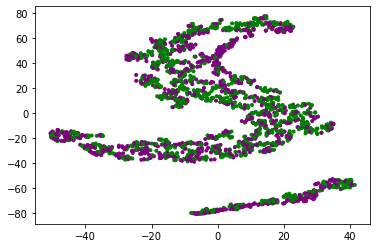

In [30]:
train_test_architecture([1, 16, 16, 16, 16, 16, 16, 16], 6)

As expected, successive transition functions result in more discriminative features being calculated, thus resulting in a more discriminative final representation of the graph (analagous to more convolutional layers in a CNN). 

Note that this notebook is just here for demonstration - the actual results here display significant variance and may vary with successive repeats of the experiment.

Epoch 0: loss 0.3042881013382049
Epoch 1: loss 0.24640204154309772
Epoch 2: loss 0.24264405904308198
Epoch 3: loss 0.23934598799262727
Epoch 4: loss 0.2361135772532887
Epoch 5: loss 0.2324246708599348
              precision    recall  f1-score   support

         web       0.67      0.45      0.54       991
          ml       0.61      0.79      0.69      1056

    accuracy                           0.63      2047
   macro avg       0.64      0.62      0.61      2047
weighted avg       0.64      0.63      0.61      2047

AUC	0.6208896163960493


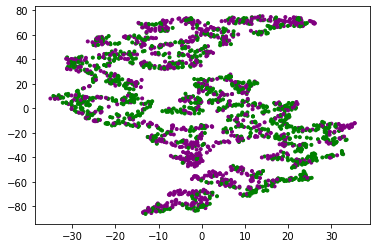

In [31]:
train_test_architecture([1, 32, 32, 32, 32, 32, 32, 32], 6)

In [32]:
print(hidden.shape)
# print(hidden)
tsne_embedded = tsne.fit_transform(hidden)
print(tsne_embedded.shape)
print(tsne_embedded[:10,])


(2047, 16)
(2047, 2)
[[ 23.743814  -20.108362 ]
 [-59.387302   38.291367 ]
 [-57.066963   35.841038 ]
 [ 32.94659   -31.020782 ]
 [ 18.491592    5.3664784]
 [ 17.834007    2.1076555]
 [ 52.629833   22.433935 ]
 [ 42.08532   -11.594258 ]
 [ 40.91013    -8.520423 ]
 [-17.922518  -31.499279 ]]
